In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV

# expanding the dislpay of tweet text for columns and rows
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)

In [2]:
# Read pre-processed data.
sunway_df_processed = pd.read_csv('sunway_df_processed.csv')
taylor_df_processed = pd.read_csv('taylor_df_processed.csv')
ucsi_df_processed = pd.read_csv('ucsi_df_processed.csv')
um_df_processed = pd.read_csv('um_df_processed.csv')
upm_df_processed = pd.read_csv('upm_df_processed.csv')
ukm_df_processed = pd.read_csv('ukm_df_processed.csv')

# Data Integration and Transformation

In [3]:
# Combine all dataframe into 1
df = pd.concat([sunway_df_processed, taylor_df_processed, ucsi_df_processed, um_df_processed, upm_df_processed
               , ukm_df_processed], ignore_index=True)

In [4]:
# Convert sentiments into integers. Positive = 1, Neutral = 0, Negative = -1.
mapping = {'positive':'1', 'neutral':'0', 'negative':'-1'}
df['Sentiment'] = df['Sentiment'].map(mapping)

In [5]:
df.head(20)

,User,Date_Created,Number_of_Likes,Source_of_Tweet,Tweet,Language,Tokenized_Tweet,Negative,Neutral,Positive,Compound,Sentiment
0,jkmkhoo,2022-09-29 13:30:47+00:00,2,Twitter Web App,this restaurant at near sunday university might suit a british palate well winkingface,en,restaurant near sunday university might suit british palate well winkingface,0.000,0.840,0.160,0.2732,1
1,eurospan,2022-09-29 09:46:32+00:00,0,Twitter Web App,exciting news sunday university press have launched a branded short story competition inspired by the un sustainable development goals you can find out more on european blow now,en,exciting news sunday university press launched branded short story competition inspired un sustainable development goal find european blow,0.000,0.752,0.248,0.7845,1
2,SunwayCPH,2022-09-29 08:30:05+00:00,4,Twitter for iPhone,check this outour chief plantar health scientist dris in the latest episode of katipunan dialogue podcast speakingheadplanetaryhealth sunwaycph sunwayuniversity upside,en,check outour chief plantar health scientist dris latest episode katipunan dialogue podcast speakingheadplanetaryhealth sunwaycph sunwayuniversity upside,0.000,1.000,0.000,0.0000,0
3,keenguyencaphe,2022-09-29 04:13:02+00:00,5,Twitter for Android,thus that was an amazing weekend as see nguyễn went on the loose to bring vietnams finest coffee into sunday university big buds keenguyensunway for all hardware and we hope one sip brings you vienna or back already winkingfacegot events do,en,thus amazing weekend see nguyễn went loose bring vietnam finest coffee sunday university big bud keenguyensunway hardware hope one sip brings vienna back already winkingfacegot event,0.049,0.809,0.143,0.6597,1
4,Mia7Jane,2022-09-28 11:16:17+00:00,1,Twitter for Android,he asked dr jane from sunday university but not malaysia grinningsquintingface mosthappeningcampus,en,asked dr jane sunday university malaysia grinningsquintingface mosthappeningcampus,0.000,1.000,0.000,0.0000,0
5,SunwayCPH,2022-09-27 06:52:59+00:00,3,Twitter for iPhone,truly one of the greatestMalaysiagreenheart thank your this special feature on our executive directorplanetaryhealth sunwaycph sunwayuniversity climatecrisis,en,truly one greatestMalaysiagreenheart thank special feature executive directorplanetaryhealth sunwaycph sunwayuniversity climatecrisis,0.000,0.633,0.367,0.7964,1
6,SunwayCPH,2022-09-27 06:17:26+00:00,4,Twitter for iPhone,thank your visiting us exciting things aheadunicefmalaysia sunwaycph planetaryhealth sunwayuniversity sunwayxfarms,en,thank visiting u exciting thing aheadunicefmalaysia sunwaycph planetaryhealth sunwayuniversity sunwayxfarms,0.000,0.612,0.388,0.6908,1
7,SunwayCPH,2022-09-27 06:17:23+00:00,4,Twitter for iPhone,we gave them the tour of wonderful sunday university camps farms amp our office at graduate centre ​we also discussed future joint research advocacy plans raisinghandsunicefmalaysia sunwaycph planetaryhealth sunwayuniversity sunwayxfarms,en,gave tour wonderful sunday university camp farm amp office graduate centre also discussed future joint research advocacy plan raisinghandsunicefmalaysia sunwaycph planetaryhealth sunwayuniversity sunwayxfarms,0.000,0.887,0.113,0.5719,1
8,SunwayCPH,2022-09-27 06:17:20+00:00,5,Twitter for iPhone,last week our friends fromvisited us ​unicefmalaysia sunwaycph planetaryhealth sunwayuniversity sunwayxfarms,en,last week friend fromvisited u unicefmalaysia sunwaycph planetaryhealth sunwayuniversity sunwayxfarms,0.000,0.763,0.237,0.4767,1
9,Mia7Jane,2022-09-26 23:38:57+00:00,3,Twitter for Android,afterweeks in france a pad student stopped me and asked are you dr jane from sunday university was she in popular i know it havana grinningsquintingface,en,afterweeks france pad student stopped asked dr jane sunday university popular know havana grinningsquintingface,0.071,0.824,0.105,0.2263,1


## Split the Dataframe

In [6]:
# State random state for reproducibility
RS = 7 

In [7]:
X = df.loc[:, 'Tweet']
Y= df.iloc[:,-1]

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = RS, stratify = df['Sentiment'])

In [9]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3325,)
(3325,)
(832,)
(832,)


In [18]:
# There is an imbalance in the target variable of traning data by looking at the percentage of sentiment.
Y_train.value_counts(normalize=True).mul(100).round(1)

1     59.1
0     28.9
-1    12.0
Name: Sentiment, dtype: float64

We can see that only 12% of tweets in training data are with negative sentiments.

In [19]:
# Percentage of sentiment in testing data.
Y_test.value_counts(normalize=True).mul(100).round(1)

1     59.0
0     29.0
-1    12.0
Name: Sentiment, dtype: float64

# Sentiment Classification

## Logistic Regression (LR)

In [10]:
stopword = nltk.corpus.stopwords.words('english')

In [28]:
%%time
# To create pipeline for algorithms.
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\b\w+\b', ngram_range=(1,1), max_features=30000)),
    ('classifier',LogisticRegression(solver='sag', random_state=RS))
    ])

CPU times: total: 0 ns
Wall time: 0 ns


In [29]:
# To fit Logistis Regression to training set.
pipeline1.fit(X_train,Y_train)
predictions1 = pipeline1.predict(X_test)
predictproba1 = pipeline1.predict_proba(X_test)

In [30]:
# To evaluate the performance of the algorithms to testing set.
print('Classification report', classification_report(Y_test, predictions1), sep='\n')
print('Confusion Matrix', confusion_matrix(Y_test,predictions1),sep='\n')
print("\nAUC ROC Score:", roc_auc_score(Y_test,predictproba1, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.91      0.10      0.18       100
           0       0.78      0.47      0.59       241
           1       0.70      0.97      0.81       491

    accuracy                           0.72       832
   macro avg       0.80      0.51      0.53       832
weighted avg       0.75      0.72      0.67       832

Confusion Matrix
[[ 10  16  74]
 [  0 114 127]
 [  1  16 474]]

AUC ROC Score: 0.8645130499074979


In [31]:
%%time
# For accuracy score of algorithms with cross validation.
sk_folds = StratifiedKFold(n_splits = 10)
scores = cross_val_score(pipeline1, X_train, Y_train, cv = sk_folds)
print("Average CV Accuracy Score: ", scores.mean())

Average CV Accuracy Score:  0.7160877745215095
CPU times: total: 1.25 s
Wall time: 1.26 s


## Multinomial Naive Baiyes (NB)

In [32]:
%%time
# To create pipeline for algorithms.
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\b\w+\b', ngram_range=(1,1), max_features=30000)),
    ('classifier',MultinomialNB())
    ])

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
# To fit Multinomial NB to training set.
pipeline2.fit(X_train,Y_train)
predictions2 = pipeline2.predict(X_test)
predictproba2 = pipeline2.predict_proba(X_test)

In [34]:
# To evaluate the performance of the algorithms to testing set.
print('Classification report', classification_report(Y_test,predictions2), sep='\n')
print('Confusion Matrix', confusion_matrix(Y_test,predictions2),sep='\n')
print("\nAUC ROC Score:", roc_auc_score(Y_test,predictproba2, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       1.00      0.03      0.06       100
           0       0.90      0.15      0.25       241
           1       0.62      0.99      0.76       491

    accuracy                           0.63       832
   macro avg       0.84      0.39      0.36       832
weighted avg       0.74      0.63      0.53       832

Confusion Matrix
[[  3   1  96]
 [  0  35 206]
 [  0   3 488]]

AUC ROC Score: 0.8371405470147537


In [35]:
%%time
sk_folds = StratifiedKFold(n_splits = 10)
scores = cross_val_score(pipeline2, X_train, Y_train, cv = sk_folds)
print("Average CV Accuracy Score: ", scores.mean())

Average CV Accuracy Score:  0.6267601939288686
CPU times: total: 984 ms
Wall time: 1 s


## Support Vector Machine (SVM)

In [36]:
# To create pipeline for algorithms.
pipeline3 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\b\w+\b', ngram_range=(1,1), max_features=30000)),
                ('classifier', OneVsRestClassifier(SVC(probability=True, random_state=RS), n_jobs=-1))
            ])

In [37]:
%%time
# To fit Support Vector Machine to the training set.
pipeline3.fit(X_train,Y_train)
predictions3 = pipeline3.predict(X_test)
predictproba3 = pipeline3.predict_proba(X_test)

CPU times: total: 1.92 s
Wall time: 11.8 s


In [38]:
# To evaluate the performance of the algorithms to testing set.
print('Classification report', classification_report(Y_test, predictions3), sep='\n')
print('Confusion Matrix', confusion_matrix(Y_test, predictions3),sep='\n')
print("\nAUC ROC Score:", roc_auc_score(Y_test,predictproba3, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.94      0.15      0.26       100
           0       0.86      0.40      0.55       241
           1       0.68      0.98      0.81       491

    accuracy                           0.71       832
   macro avg       0.83      0.51      0.54       832
weighted avg       0.77      0.71      0.67       832

Confusion Matrix
[[ 15   7  78]
 [  0  97 144]
 [  1   9 481]]

AUC ROC Score: 0.8656640959463348


In [39]:
%%time
sk_folds = StratifiedKFold(n_splits = 10)
scores = cross_val_score(pipeline3, X_train, Y_train, cv = sk_folds)
print("Average CV Accuracy Score: ", scores.mean())

Average CV Accuracy Score:  0.704058576648938
CPU times: total: 4.34 s
Wall time: 1min 8s


## Decision Tree (DT)

In [40]:
# To create pipeline for algorithms.
pipeline4 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\w{1,}', ngram_range=(1,1), max_features=30000)),
                ('classifier', DecisionTreeClassifier(random_state=RS))
            ])

In [41]:
%%time
# To fit Decision Tree to the training set.
pipeline4.fit(X_train,Y_train)
predictions4 = pipeline4.predict(X_test)
predictproba4 = pipeline4.predict_proba(X_test)

CPU times: total: 1.45 s
Wall time: 1.45 s


In [42]:
# To evaluate the performance of the algorithms to testing set.
print("Classification report", classification_report(Y_test, predictions4), sep="\n")
print("Confusion Matrix", confusion_matrix(Y_test, predictions4),sep="\n")
print("\nAUC ROC Score:", roc_auc_score(Y_test,predictproba4, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.46      0.29      0.36       100
           0       0.48      0.58      0.53       241
           1       0.73      0.71      0.72       491

    accuracy                           0.62       832
   macro avg       0.56      0.53      0.53       832
weighted avg       0.63      0.62      0.62       832

Confusion Matrix
[[ 29  32  39]
 [ 13 140  88]
 [ 21 120 350]]

AUC ROC Score: 0.6619633468096802


In [43]:
%%time
# For accuracy score of algorithms with cross validation.
sk_folds = StratifiedKFold(n_splits = 10)
scores = cross_val_score(pipeline4, X_train, Y_train, cv = sk_folds)
print("Average CV Accuracy Score: ", scores.mean())

Average CV Accuracy Score:  0.6279767719526756
CPU times: total: 11.7 s
Wall time: 11.7 s


## Random Forest (RF)

In [44]:
# To create pipeline for algorithms.
pipeline5 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\b\w+\b', ngram_range=(1,1), max_features=30000)),
                ('classifier', RandomForestClassifier(random_state=RS, n_jobs=-1))
            ])

In [45]:
%%time
# To fit Random Forest to the training set.
pipeline5.fit(X_train,Y_train)
predictions5 = pipeline5.predict(X_test)
predictproba5 = pipeline5.predict_proba(X_test)

CPU times: total: 13.1 s
Wall time: 1.98 s


In [46]:
# To evaluate the performance of the algorithms to testing set.
print("Classification report", classification_report(Y_test, predictions5), sep="\n")
print("Confusion Matrix", confusion_matrix(Y_test, predictions5),sep="\n")
print("\nAUC ROC Score:", roc_auc_score(Y_test,predictproba5, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.92      0.22      0.35       100
           0       0.62      0.67      0.65       241
           1       0.75      0.84      0.79       491

    accuracy                           0.72       832
   macro avg       0.76      0.58      0.60       832
weighted avg       0.73      0.72      0.70       832

Confusion Matrix
[[ 22  21  57]
 [  0 162  79]
 [  2  78 411]]

AUC ROC Score: 0.8446858194725516


In [47]:
%%time
sk_folds = StratifiedKFold(n_splits = 10)
scores = cross_val_score(pipeline5, X_train, Y_train, cv = sk_folds)
print("Average CV Accuracy Score: ", scores.mean())

Average CV Accuracy Score:  0.7179022395889866
CPU times: total: 3.31 s
Wall time: 17.4 s


## Gradient Boosting (GB)

In [48]:
# To create pipeline for algorithms.
pipeline6 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\b\w+\b', ngram_range=(1,1), max_features=30000)),
                ('classifier', GradientBoostingClassifier(random_state=RS))
            ])

In [49]:
# To fit Gradient Boosting to the training set.
pipeline6.fit(X_train,Y_train)
predictions6 = pipeline6.predict(X_test)
predictproba6 = pipeline6.predict_proba(X_test)

In [50]:
# To evaluate the performance of the algorithms to testing set.
print("Classification report", classification_report(Y_test, predictions6), sep="\n")
print("Confusion Matrix", confusion_matrix(Y_test, predictions6),sep="\n")
print("\nAUC ROC Score:", roc_auc_score(Y_test,predictproba6, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.72      0.28      0.40       100
           0       0.64      0.53      0.58       241
           1       0.71      0.86      0.78       491

    accuracy                           0.70       832
   macro avg       0.69      0.56      0.59       832
weighted avg       0.69      0.70      0.68       832

Confusion Matrix
[[ 28  13  59]
 [  1 128 112]
 [ 10  58 423]]

AUC ROC Score: 0.8322041396151942


In [51]:
%%time
sk_folds = StratifiedKFold(n_splits = 10)
scores = cross_val_score(pipeline6, X, Y, cv = sk_folds)
print("Average CV Accuracy Score: ", scores.mean())

Average CV Accuracy Score:  0.668011468952734
CPU times: total: 2min 23s
Wall time: 2min 23s


# Hyperparameter Tuning

## LR

In [52]:
%%time
# Hyperparameter tuning for LR
hyppipe1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', 
                              token_pattern=r'\b\w+\b', analyzer='word', ngram_range=(1,1))),
     ('classifier',LogisticRegression(class_weight='balanced', random_state=RS))
    ])

param_grid1 = {'tfidf__max_features': [10000, 30000],
              'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             } 

grid = GridSearchCV(hyppipe1, param_grid1, cv=10, scoring='roc_auc_ovr_weighted', n_jobs=-1)

grid1 = grid.fit(X_train, Y_train)

CPU times: total: 1.58 s
Wall time: 9.59 s


In [53]:
print(grid1.best_estimator_.named_steps['classifier'])
print(grid1.best_estimator_.named_steps['tfidf'])

LogisticRegression(class_weight='balanced', random_state=7)
TfidfVectorizer(max_features=10000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\b\\w+\\b')


In [54]:
grid1.best_params_

{'classifier__solver': 'lbfgs', 'tfidf__max_features': 10000}

In [55]:
hypepredictions1 = grid1.predict(X_test)
hypepredictproba1 = grid1.predict_proba(X_test)

In [56]:
# To evaluate the performance of the algorithms to testing set after hyperparameter tuning.
print('Classification report', classification_report(Y_test, hypepredictions1), sep='\n')
print('Confusion Matrix', confusion_matrix(Y_test,hypepredictions1),sep='\n')
print("\nAUC ROC Score:", roc_auc_score(Y_test,hypepredictproba1, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.48      0.53      0.50       100
           0       0.64      0.71      0.67       241
           1       0.83      0.77      0.80       491

    accuracy                           0.72       832
   macro avg       0.65      0.67      0.66       832
weighted avg       0.73      0.72      0.73       832

Confusion Matrix
[[ 53  19  28]
 [ 22 170  49]
 [ 36  77 378]]

AUC ROC Score: 0.8638383944861731


## SVM

In [18]:
%%time
# Hyperparameter tuning for SVM
hyppipe2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', 
                              token_pattern=r'\b\w+\b', analyzer='word', ngram_range=(1, 1))),
     ('classifier',OneVsRestClassifier(SVC(probability=True, class_weight='balanced', random_state=RS)))
    ])

param_grid2 = {'tfidf__max_features': [10000, 30000],
               'classifier__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
             } 

grid = GridSearchCV(hyppipe2, param_grid2, cv=10, scoring='roc_auc_ovr_weighted', n_jobs = -1)

grid2 = grid.fit(X_train, Y_train)

C:\Users\User\anaconda3\envs\alan_project\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\alan_project\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\alan_project\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\User\anaconda3\envs\alan_project\lib\site-packages\sklearn\multiclass.py", line 327, in fi

CPU times: total: 21.2 s
Wall time: 6min 50s


In [19]:
print(grid2.best_estimator_.named_steps['classifier'])
print(grid2.best_estimator_.named_steps['tfidf'])

OneVsRestClassifier(estimator=SVC(class_weight='balanced', kernel='linear',
                                  probability=True, random_state=7))
TfidfVectorizer(max_features=10000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\b\\w+\\b')


In [20]:
grid2.best_params_

{'classifier__estimator__kernel': 'linear', 'tfidf__max_features': 10000}

In [21]:
hypepredictions2 = grid2.predict(X_test)
hypepredictproba2 = grid2.predict_proba(X_test)

In [22]:
# To evaluate the performance of the algorithms to testing set after hyperparameter tuning.
print('Classification report', classification_report(Y_test, hypepredictions2), sep='\n')
print('Confusion Matrix', confusion_matrix(Y_test,hypepredictions2),sep='\n')
print("\nAUC ROC Score:", roc_auc_score(Y_test,hypepredictproba2, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.65      0.51      0.57       100
           0       0.67      0.76      0.71       241
           1       0.84      0.82      0.83       491

    accuracy                           0.77       832
   macro avg       0.72      0.70      0.70       832
weighted avg       0.77      0.77      0.77       832

Confusion Matrix
[[ 51  23  26]
 [  9 182  50]
 [ 19  67 405]]

AUC ROC Score: 0.8825327229023052


## RF

In [65]:
%%time
# Hyperparameter tuning for RF
hyppipe3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', 
                              token_pattern=r'\b\w+\b', analyzer='word', ngram_range=(1, 1))),
     ('classifier',RandomForestClassifier(class_weight='balanced', random_state=RS))
    ])

max_feature = [10000, 30000]
n_estimators = [100, 500, 1000, 2000]
max_depth = [10, 50, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 5, 10] 

param_grid3 = {'tfidf__max_features': max_feature,    
               'classifier__n_estimators': n_estimators,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': [True, False]
             } 

grid = GridSearchCV(hyppipe3, param_grid3, cv=10, scoring='roc_auc_ovr_weighted', n_jobs=-1)

grid3 = grid.fit(X_train, Y_train)

CPU times: total: 5min 55s
Wall time: 5h 25min 16s


In [66]:
print(grid3.best_estimator_.named_steps['classifier'])
print(grid3.best_estimator_.named_steps['tfidf'])

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_split=5, n_estimators=2000, random_state=7)
TfidfVectorizer(max_features=30000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\b\\w+\\b')


In [67]:
grid3.best_params_

{'classifier__bootstrap': False,
 'classifier__max_depth': None,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 2000,
 'tfidf__max_features': 30000}

In [68]:
hypepredictions3 = grid3.predict(X_test)
hypepredictproba3 = grid3.predict_proba(X_test)

In [69]:
# To evaluate the performance of the algorithms to testing set after hyperparameter tuning.
print('Classification report', classification_report(Y_test, hypepredictions3), sep='\n')
print('Confusion Matrix', confusion_matrix(Y_test,hypepredictions3),sep='\n')
print("\nAUC ROC Score:", roc_auc_score(Y_test,hypepredictproba3, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.78      0.38      0.51       100
           0       0.58      0.81      0.68       241
           1       0.83      0.76      0.79       491

    accuracy                           0.73       832
   macro avg       0.73      0.65      0.66       832
weighted avg       0.75      0.73      0.73       832

Confusion Matrix
[[ 38  31  31]
 [  2 195  44]
 [  9 109 373]]

AUC ROC Score: 0.8678173119321954


# Stacking Models

In [57]:
stack = StackingClassifier([
    ('LR', LogisticRegression(n_jobs=-1, random_state=RS)),
    ('SVM',OneVsRestClassifier(SVC(probability=True, random_state=RS, 
                                       kernel='linear'), n_jobs=-1)),
    ('RF', RandomForestClassifier(n_jobs=-1, random_state=RS))
    ])

In [58]:
%%time
stack_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\b\w+\b', ngram_range=(1,1), max_features=30000)),
    ('stack', stack),
])

stack_pipeline.fit(X_train, Y_train)
stack_prediction = stack_pipeline.predict(X_test)
stack_predictproba = stack_pipeline.predict_proba(X_test)

CPU times: total: 6.8 s
Wall time: 59 s


In [59]:
# To evaluate the performance of the algorithms to testing set.
print("Classification report", classification_report(Y_test, stack_prediction), sep="\n")
print("Confusion Matrix", confusion_matrix(Y_test, stack_prediction),sep="\n")
print("\nAUC ROC Score:", roc_auc_score(Y_test,stack_predictproba, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.77      0.43      0.55       100
           0       0.68      0.74      0.71       241
           1       0.81      0.85      0.83       491

    accuracy                           0.77       832
   macro avg       0.75      0.67      0.70       832
weighted avg       0.77      0.77      0.76       832

Confusion Matrix
[[ 43  22  35]
 [  2 179  60]
 [ 11  62 418]]

AUC ROC Score: 0.8860161872240947


# Hyperparameter for Stacking Model

In [23]:
%%time
stack = StackingClassifier([
    ('LR', LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RS)),
    ('SVM',OneVsRestClassifier(SVC(class_weight='balanced', probability=True, random_state=RS, 
                                       kernel='linear'), n_jobs=-1)),
    ('RF', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=RS))
    ])

stack_hyppipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopword, sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                              token_pattern=r'\b\w+\b', ngram_range=(1,1))),
    ('stack', stack),
])

max_feature = [5000, 10000, 30000]
n_estimators = [100, 500, 1000]
min_samples_split = [2, 5, 10]

stack_param_grid = {'tfidf__max_features': max_feature,
                    'stack__RF__n_estimators': n_estimators,
                    'stack__RF__min_samples_split': min_samples_split,
                    'stack__RF__bootstrap': [True, False]
                   }

grid = GridSearchCV(stack_hyppipe, stack_param_grid, cv=10, scoring='roc_auc_ovr_weighted', n_jobs=-1)

stackgrid = grid.fit(X_train, Y_train)

CPU times: total: 16.9 s
Wall time: 13h 24min 45s


In [24]:
print(stackgrid.best_estimator_.named_steps['stack'])
print(stackgrid.best_estimator_.named_steps['tfidf'])

StackingClassifier(estimators=[('LR',
                                LogisticRegression(class_weight='balanced',
                                                   n_jobs=-1, random_state=7)),
                               ('SVM',
                                OneVsRestClassifier(estimator=SVC(class_weight='balanced',
                                                                  kernel='linear',
                                                                  probability=True,
                                                                  random_state=7),
                                                    n_jobs=-1)),
                               ('RF',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight='balanced',
                                                       n_estimators=500,
                                                       n_jobs=-1,
                                

In [25]:
stackgrid.best_params_

{'stack__RF__bootstrap': False,
 'stack__RF__min_samples_split': 2,
 'stack__RF__n_estimators': 500,
 'tfidf__max_features': 5000}

In [26]:
stack_hypepredictions = stackgrid.predict(X_test)
stack_hypepredictproba = stackgrid.predict_proba(X_test)

In [27]:
# To evaluate the performance of the algorithms to testing set after hyperparameter tuning.
print('Classification report', classification_report(Y_test, stack_hypepredictions), sep='\n')
print('Confusion Matrix', confusion_matrix(Y_test,stack_hypepredictions),sep='\n')
print("\nAUC ROC Score:", roc_auc_score(Y_test,stack_hypepredictproba, multi_class='ovr', average='weighted'))

Classification report
              precision    recall  f1-score   support

          -1       0.76      0.47      0.58       100
           0       0.74      0.76      0.75       241
           1       0.82      0.88      0.85       491

    accuracy                           0.79       832
   macro avg       0.77      0.70      0.73       832
weighted avg       0.79      0.79      0.79       832

Confusion Matrix
[[ 47  16  37]
 [  3 182  56]
 [ 12  48 431]]

AUC ROC Score: 0.8991030597693399


# Graphs

## Before Hyperparameter Tuning

In [70]:
# Assign value of all performance metrics before hyperparameter tuning
accuracy1 = round(accuracy_score(Y_test, predictions1),3)
accuracy2 = round(accuracy_score(Y_test, predictions2),3)
accuracy3 = round(accuracy_score(Y_test, predictions3),3)
accuracy4 = round(accuracy_score(Y_test, predictions4),3)
accuracy5 = round(accuracy_score(Y_test, predictions5),3)
accuracy6 = round(accuracy_score(Y_test, predictions6),3)
accuracy7 = round(accuracy_score(Y_test, stack_prediction),3)
precision1,recall1,fscore1,support1 = score(Y_test,predictions1,average='weighted')
precision2,recall2,fscore2,support2 = score(Y_test,predictions2,average='weighted')
precision3,recall3,fscore3,support3 = score(Y_test,predictions3,average='weighted')
precision4,recall4,fscore4,support4 = score(Y_test,predictions4,average='weighted')
precision5,recall5,fscore5,support5 = score(Y_test,predictions5,average='weighted')
precision6,recall6,fscore6,support6 = score(Y_test,predictions6,average='weighted')
precision7,recall7,fscore7,support7 = score(Y_test,stack_prediction,average='weighted')
AUCROC1 = round(roc_auc_score(Y_test,predictproba1, multi_class='ovr', average='weighted'),3)
AUCROC2 = round(roc_auc_score(Y_test,predictproba2, multi_class='ovr', average='weighted'),3)
AUCROC3 = round(roc_auc_score(Y_test,predictproba3, multi_class='ovr', average='weighted'),3)
AUCROC4 = round(roc_auc_score(Y_test,predictproba4, multi_class='ovr', average='weighted'),3)
AUCROC5 = round(roc_auc_score(Y_test,predictproba5, multi_class='ovr', average='weighted'),3)
AUCROC6 = round(roc_auc_score(Y_test,predictproba6, multi_class='ovr', average='weighted'),3)
AUCROC7 = round(roc_auc_score(Y_test,stack_predictproba, multi_class='ovr', average='weighted'),3)

In [71]:
# Form dataframe for performance metrics before hyperparameter tuning
performetrictbl = pd.DataFrame({
    'Model': ['LR', 'Multinomial NB', 'SVM', 'DT', 'RF', 'GB', 'Stacking'],
    'Accuracy': [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6, accuracy7],
    'Precision': list(map(lambda x:round(x,3),[precision1, precision2, precision3, precision4, precision5, precision6,
                                              precision7])),
    'Recall': list(map(lambda x:round(x,3),[recall1, recall2, recall3, recall4, recall5, recall6, recall7])),
    'F-Measure': list(map(lambda x:round(x,3),[fscore1, fscore2, fscore3, fscore4, fscore5, fscore6, fscore7])),
    'AUC ROC': [AUCROC1, AUCROC2, AUCROC3, AUCROC4, AUCROC5, AUCROC6, AUCROC7]
})

performetrictbl

,Model,Accuracy,Precision,Recall,F-Measure,AUC ROC
0,LR,0.719,0.750,0.719,0.672,0.865
1,Multinomial NB,0.632,0.745,0.632,0.529,0.837
2,SVM,0.713,0.765,0.713,0.665,0.866
3,DT,0.624,0.627,0.624,0.622,0.662
4,RF,0.715,0.733,0.715,0.697,0.845
5,GB,0.696,0.693,0.696,0.677,0.832
6,Stacking,0.769,0.770,0.769,0.763,0.886


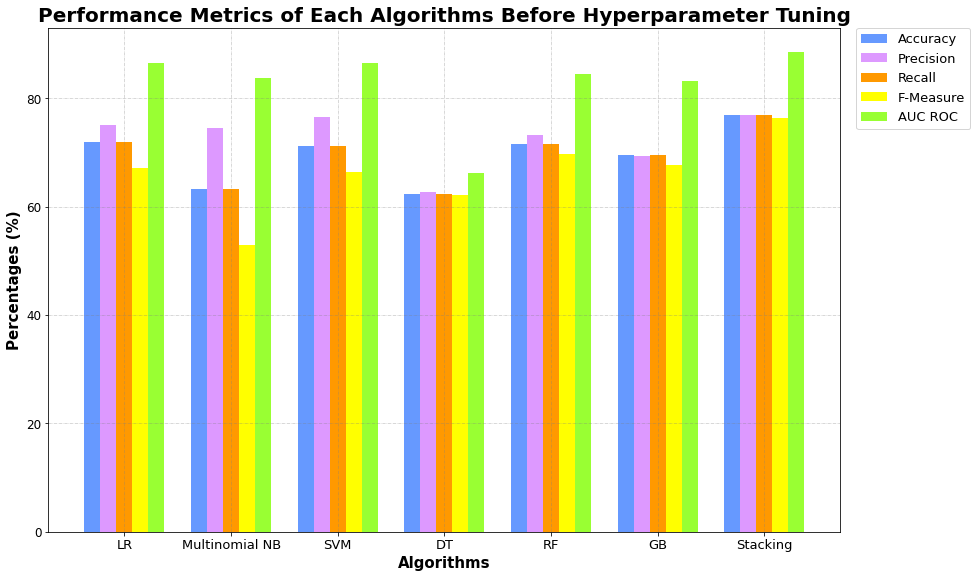

In [72]:
# Plot a bar chart to display the dataframe for performance metrics before hyperparameter tuning

fig = plt.figure(figsize =(11, 7))

# set width of bar
barWidth = 0.15

ax = fig.add_axes([0,0,1,1])

# Set position of bar on X axis
br1 = np.arange(performetrictbl.shape[0])
br2 = br1 + barWidth
br3 = br2 + barWidth
br4 = br3 + barWidth
br5 = br4 + barWidth

ax.bar(br1, performetrictbl['Accuracy']*100, color = '#6699ff', width = barWidth, label = 'Accuracy')
ax.bar(br2, performetrictbl['Precision']*100, color = '#dd99ff', width = barWidth, label = 'Precision')
ax.bar(br3, performetrictbl['Recall']*100, color = '#ff9900', width = barWidth, label = 'Recall')
ax.bar(br4, performetrictbl['F-Measure']*100, color = '#ffff00', width = barWidth, label = 'F-Measure')
ax.bar(br5, performetrictbl['AUC ROC']*100, color = '#99ff33', width = barWidth, label = 'AUC ROC')

ax.set_title('Performance Metrics of Each Algorithms Before Hyperparameter Tuning', fontsize = 20, fontweight ='bold')
ax.set_xlabel('Algorithms', fontsize = 15, fontweight ='bold')
ax.set_ylabel('Percentages (%)', fontsize = 15, fontweight ='bold')

# Add x, y gridlines
ax.grid(visible = True, color ='grey',
         linestyle ='-.', linewidth = 0.5,
         alpha = 0.6)

# Name the algorithms in x-axis
plt.xticks([x + 2*barWidth for x in range(performetrictbl.shape[0])], list(performetrictbl['Model']), fontsize = 13)
plt.yticks(fontsize = 12)
   
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 13)
plt.show()

### AUC ROC graph

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

Unable to plot AUC ROC graph for weighted average AUCROC

## After Hyperparameter Tuning and Stacking

In [73]:
# Assign value of all performance metrics after hyperparameter tuning and stacking
hypeaccuracy1 = round(accuracy_score(Y_test, hypepredictions1),3)
hypeaccuracy2 = round(accuracy_score(Y_test, hypepredictions2),3)
hypeaccuracy3 = round(accuracy_score(Y_test, hypepredictions3),3)
stackaccuracy = round(accuracy_score(Y_test, stack_hypepredictions),3)
hypeprecision1,hyperecall1,hypefscore1,hypesupport1 = score(Y_test,hypepredictions1,average='weighted')
hypeprecision2,hyperecall2,hypefscore2,hypesupport2 = score(Y_test,hypepredictions2,average='weighted')
hypeprecision3,hyperecall3,hypefscore3,hypesupport3 = score(Y_test,hypepredictions3,average='weighted')
stackprecision, stackrecall, stackfscore, stacksupport = score(Y_test,stack_hypepredictions,average='weighted')
hypeAUCROC1 = round(roc_auc_score(Y_test,hypepredictproba1, multi_class='ovr', average='weighted'),3)
hypeAUCROC2 = round(roc_auc_score(Y_test,hypepredictproba2, multi_class='ovr', average='weighted'),3)
hypeAUCROC3 = round(roc_auc_score(Y_test,hypepredictproba3, multi_class='ovr', average='weighted'),3)
stackAUCROC = round(roc_auc_score(Y_test,stack_hypepredictproba, multi_class='ovr', average='weighted'),3)

In [74]:
# Form dataframe for performance metrics after hyperparameter tuning
hypeperformetrictbl = pd.DataFrame({
    'Model': ['LR', 'SVM', 'RF', 'Stacking'],
    'Accuracy': [hypeaccuracy1, hypeaccuracy2, hypeaccuracy3, stackaccuracy],
    'Precision': list(map(lambda x:round(x,3),[hypeprecision1, hypeprecision2, hypeprecision3, stackprecision])),
    'Recall': list(map(lambda x:round(x,3),[hyperecall1, hyperecall2, hyperecall3, stackrecall])),
    'F1-Score': list(map(lambda x:round(x,3),[hypefscore1, hypefscore2, hypefscore3, stackfscore])),
    'AUC ROC': [hypeAUCROC1, hypeAUCROC2, hypeAUCROC3, stackAUCROC]
})

hypeperformetrictbl

,Model,Accuracy,Precision,Recall,F1-Score,AUC ROC
0,LR,0.722,0.733,0.722,0.726,0.864
1,SVM,0.767,0.768,0.767,0.766,0.883
2,RF,0.728,0.753,0.728,0.726,0.868
3,Stacking,0.793,0.791,0.793,0.787,0.899


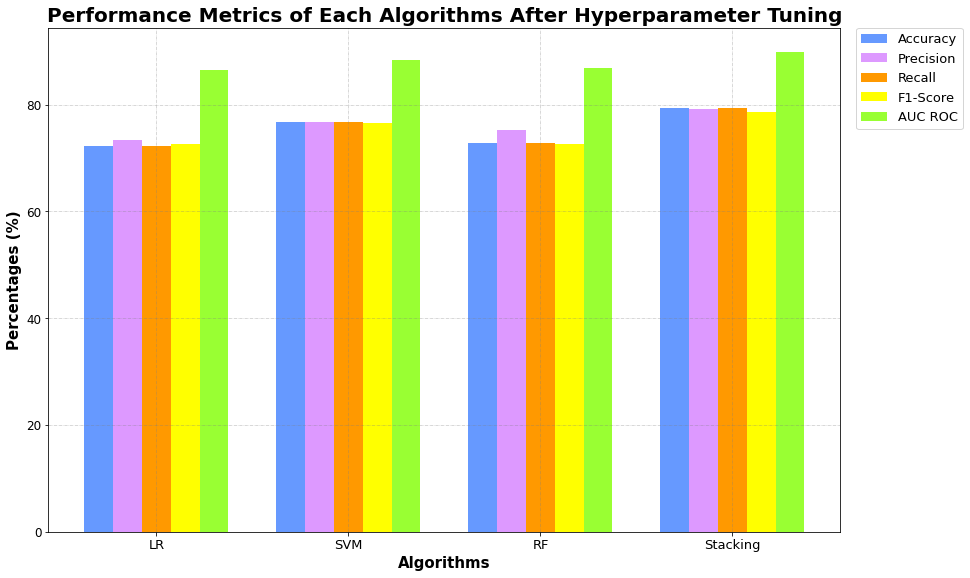

In [75]:
# Plot a bar chart to display the dataframe for performance metrics after hyperparameter tuning

fig = plt.figure(figsize =(11, 7))

# set width of bar
barWidth = 0.15

ax = fig.add_axes([0,0,1,1])

# Set position of bar on X axis
br1 = np.arange(hypeperformetrictbl.shape[0])
br2 = br1 + barWidth
br3 = br2 + barWidth
br4 = br3 + barWidth
br5 = br4 + barWidth

ax.bar(br1, hypeperformetrictbl['Accuracy']*100, color = '#6699ff', width = barWidth, label = 'Accuracy')
ax.bar(br2, hypeperformetrictbl['Precision']*100, color = '#dd99ff', width = barWidth, label = 'Precision')
ax.bar(br3, hypeperformetrictbl['Recall']*100, color = '#ff9900', width = barWidth, label = 'Recall')
ax.bar(br4, hypeperformetrictbl['F1-Score']*100, color = '#ffff00', width = barWidth, label = 'F1-Score')
ax.bar(br5, hypeperformetrictbl['AUC ROC']*100, color = '#99ff33', width = barWidth, label = 'AUC ROC')

ax.set_title('Performance Metrics of Each Algorithms After Hyperparameter Tuning', 
             fontsize = 20, fontweight ='bold')
ax.set_xlabel('Algorithms', fontsize = 15, fontweight ='bold')
ax.set_ylabel('Percentages (%)', fontsize = 15, fontweight ='bold')

# Add x, y gridlines
ax.grid(visible = True, color ='grey',
         linestyle ='-.', linewidth = 0.5,
         alpha = 0.6)

# Name the algorithms in x-axis
plt.xticks([x + 2*barWidth for x in range(hypeperformetrictbl.shape[0])], list(hypeperformetrictbl['Model']), fontsize = 13)
plt.yticks(fontsize = 12)
   
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 13)
plt.show()